Link to the Blog: https://medium.com/@neha.dipali/application-of-convolutional-neural-networks-in-brain-tumor-segmentation-d3b2eb7c07ae

In [1]:
# Follow this detailed video to install Tensorflow on GPU:  https://www.youtube.com/watch?v=hHWkvEcDBO0&t=1s

import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os.path
from tensorflow.keras.models import load_model

import operator
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pylab as pl

import seaborn as sns
import matplotlib.pyplot as plt   
from IPython.display import Image, display
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print('Number of GPUs: ', len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs:  1


### Model Predictions Dataframe Initialisation

In [3]:
def open_images(paths):
    '''
    Opens a batch of images, given the image path(s) as a list
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(224,224))
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    '''
    it is possible to get the label from the path, just split the path by "/" and index -2
    For example, /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1020.jpg
    splitting by "/" gives ['kaggle','input','brain-tumor-mri-dataset','Training','pituitary','Tr-pi_1020.jpg']
    Now indexing -2 gives "pituitary"
    '''
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

train_dir = r'Training/'
test_dir = r'Testing/'

train_paths = []
test_paths = []


for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)


for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)

labels_test = os.listdir(test_dir)
labels_train = os.listdir(train_dir)

model_predictions_train = pd.DataFrame(columns = ['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained','actual'], 
                                       index = train_paths ).fillna('here')

model_predictions_test = pd.DataFrame(columns = ['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained','actual'], 
                                       index = test_paths ).fillna('here')

### Loading Data and Augmentation

In [4]:
generator_train = ImageDataGenerator(rescale=1/255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     shear_range=0.1,
                                     height_shift_range=0.07,
                                     zoom_range=0.1)


train = generator_train.flow_from_directory(r'Training', target_size=(224,224), # height and width of images to feed into CNN
                                              batch_size=16, class_mode= "categorical", color_mode='rgb')


generator_test = ImageDataGenerator(rescale=1/255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     shear_range=0.1,
                                     height_shift_range=0.07,
                                     zoom_range=0.1)


test = generator_test.flow_from_directory(r'Testing', target_size=(224,224),
                                              batch_size=16, class_mode= "categorical", color_mode='rgb')

IMAGE_SIZE = [224, 224]

train_path = r'Training'
valid_path = r'Testing'

folders = glob(r'Training/*')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Model 1

In [ ]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape=(224, 224, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides = 2))

# Convolutional layer 2
model1.add(Conv2D(64,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model1.add(Conv2D(128,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Feedforward
model1.add(Dense(units= 512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

history1 = model1.fit(train, steps_per_epoch=5712//16, epochs=120, validation_data=test, validation_steps= 1311//16, callbacks=[model1_es, model1_rlr, model1_mcp])

In [5]:
if os.path.isfile('models/self_3conv_2ff.h5') is False:
    model1.save('models/self_3conv_2ff.h5')
    
self_3conv_2ff = load_model('models/self_3conv_2ff.h5')

### Model 2 - VGG16 (No Convolution Trained)

In [ ]:
vgg16_conv = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg16_conv.layers:
    layer.trainable = False

vgg_feedforward = Flatten()(vgg16_conv.output)
vgg_feedforward = Dense(4096,activation = 'relu')(vgg_feedforward)
vgg_feedforward = Dense(1024,activation = 'relu')(vgg_feedforward)

prediction = Dense(4, activation='softmax')(vgg_feedforward)

model_vgg16 = Model(inputs=vgg16_conv.input, outputs=prediction)

model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)


model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

vgg16_fit = model_vgg16.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

In [6]:
if os.path.isfile('models/vgg16_4096_1024.h5') is False:
    model1.save('models/vgg16_4096_1024.h5')

vgg16_4096_1024 = load_model('models/vgg16_4096_1024.h5')
print(vgg16_4096_1024.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###  Model 3 - VGG16 (Last Convolution Trained)

In [ ]:
vgg16_conv = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg16_conv.layers[:15]:
    layer.trainable = False

vgg_feedforward = Flatten()(vgg16_conv.output)
vgg_feedforward = Dense(64,activation = 'relu')(vgg_feedforward)
vgg_feedforward = Dense(16,activation = 'relu')(vgg_feedforward)

prediction = Dense(len(folders), activation='softmax')(vgg_feedforward)

model_vgg16 = Model(inputs=vgg16_conv.input, outputs=prediction)

model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)


model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

vgg16_fit = model_vgg16.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

In [7]:
if os.path.isfile('models/vgg16_64_16_last_conv_train.h5') is False:
    model_vgg16.save('models/vgg16_64_16_last_conv_train.h5')

vgg16_64_16_last_conv_trained = load_model('models/vgg16_64_16_last_conv_train.h5')
print(vgg16_64_16_last_conv_trained.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Model 4 - ResNet150 (No Convolution Trained)

In [ ]:
ResNet_conv = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ResNet_conv.layers:
    layer.trainable = False

resnet_feedforword = Flatten()(ResNet_conv.output)

prediction = Dense(len(folders), activation='softmax')(resnet_feedforword)

model_ResNet = Model(inputs= ResNet_conv.input, outputs=prediction)

model_ResNet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_ResNet_fit = model_ResNet.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

In [8]:
if os.path.isfile('models/resnet152.h5') is False:
    model_ResNet.save('models/resnet152.h5')

resnet152 = load_model('models/resnet152.h5')
print(resnet152.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Model 5 - ResNet150 (Last 2 Convolution Trained)

In [ ]:
ResNet_conv = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ResNet_conv.layers[-7:]:
    layer.trainable = False    

resnet_feedforword = Flatten()(ResNet_conv.output)

prediction = Dense(len(folders), activation='softmax')(resnet_feedforword)

model_ResNet = Model(inputs= ResNet_conv.input, outputs=prediction)

model_ResNet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_ResNet_fit = model_ResNet.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

In [9]:
if os.path.isfile('models/resnet152_2conv_train.h5') is False:
    model_ResNet.save('models/resnet152_2conv_train.h5')
    
resnet152_2conv_trained = load_model('models/resnet152_2conv_train.h5')
print(resnet152_2conv_trained.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Model 6 - InceptionV3 

In [ ]:
inception_conv = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception_conv.layers:
    layer.trainable = False    

inception_feedforword = Flatten()(inception_conv.output)
inception_feedforword = Dense(1024,activation = 'relu')(inception_feedforword)

prediction = Dense(len(folders), activation='softmax')(inception_feedforword)

model_inception = Model(inputs= inception_conv.input, outputs=prediction)

model_inception.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_inception_fit = model_inception.fit(
  train,
  validation_data=test,
  epochs=20,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

In [10]:
# Converged in ~15 epochs, fastest. 

if os.path.isfile('models/inception.h5') is False:
    model_inception.save('models/inception.h5')
     
inception = load_model('models/inception.h5')
print(inception.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Model 7 - InceptionV3 - Conv Trained

In [ ]:
base_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for i,layer in enumerate(base_model.layers):
    layer.trainable = False
    if layer.name == 'mixed7':
        break

# for layer in inception_conv.layers[:279]:
#     layer.trainable = False    

inception_feedforword = Flatten()(base_model.output)
inception_feedforword = Dense(64,activation = 'relu')(inception_feedforword)
prediction = Dense(len(folders), activation='softmax')(inception_feedforword)

model_inception = Model(inputs= base_model.input, outputs=prediction)

model_inception.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_inception_fit = model_inception.fit(
  train,
  validation_data=test,
  epochs=15,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

In [11]:
if os.path.isfile('models/inception_conv_trained.h5') is False:
    model_inception.save('models/inception_conv_trained.h5')
    
inception_conv_trained = load_model('models/inception_conv_trained.h5')
print(inception_conv_trained.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_564 (Batch  (None, 111, 111, 32  96         ['conv2d_564[0][0]']             
 Normalization)                 )                                                           

### Testing Model Predictions

In [ ]:
for i in train_paths:
    images = open_images([i])
    
    predicted = self_3conv_2ff.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
#     plt.imshow(images[0])
#     print(test_paths[i])
#     print('Predicted:', predicted)
#     print('Actual:', label)
    model_predictions_train.loc[i,'3c2f'] = predicted
    
    predicted = vgg16_4096_1024.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'vgg16'] = predicted
    
    predicted = vgg16_64_16_last_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'vgg16_ctrained'] = predicted
    
    predicted = resnet152.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'resnet'] = predicted
    
    predicted = resnet152_2conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'resnet_ctrained'] = predicted
    
    predicted = inception.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'inception'] = predicted
    
    predicted = inception_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'inception_ctrained'] = predicted
    
    label = i.split('/')[-2]
    model_predictions_train.loc[i,'actual'] = label

    
for i in test_paths:
    images = open_images([i])
    
    predicted = self_3conv_2ff.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'3c2f'] = predicted
    
    predicted = vgg16_4096_1024.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'vgg16'] = predicted
    
    predicted = vgg16_64_16_last_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'vgg16_ctrained'] = predicted
    
    predicted = resnet152.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'resnet'] = predicted
    
    predicted = resnet152_2conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'resnet_ctrained'] = predicted
    
    predicted = inception.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'inception'] = predicted
    
    predicted = inception_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'inception_ctrained'] = predicted
    
    label = i.split('/')[-2]
    model_predictions_test.loc[i,'actual'] = label
    
model_predictions_train.to_csv('model_predictions_train.csv')
model_predictions_test.to_csv('model_predictions_test.csv')

###  Gradient Activation Maps

#### VGG16

In [12]:
def vgg16_gradient_activation_maps(img_path,correct_class):
    _img = keras.preprocessing.image.load_img(img_path,target_size=(224,224))
    
    model2 = Sequential()
    for layer in vgg16_64_16_last_conv_trained.layers[:-3]: # go through until last layer
        model2.add(layer)

    img = keras.preprocessing.image.img_to_array(_img )
    img = img.reshape((1, *img.shape))
    y_pred = model2.predict(img)

    images = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = model2(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    dgrad_abs = tf.math.abs(grads)

    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    fig, axes = plt.subplots(1,3,figsize=(21,5))
    axes[0].imshow(_img)
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=1)

    axes[2].imshow(_img, cmap='gray') # I would add interpolation='none'
    axes[2].imshow(grad_eval,cmap="jet", alpha=0.5) # interpolation='none'

    fig.colorbar(i)

    print(correct_class)

glioma


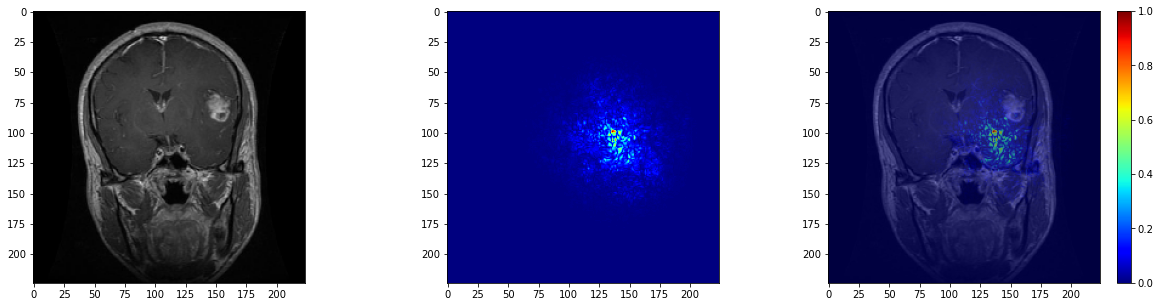

In [13]:
warnings.filterwarnings("ignore")
vgg16_gradient_activation_maps(r'Testing/glioma/Te-gl_0137.jpg', 'glioma')

meningioma


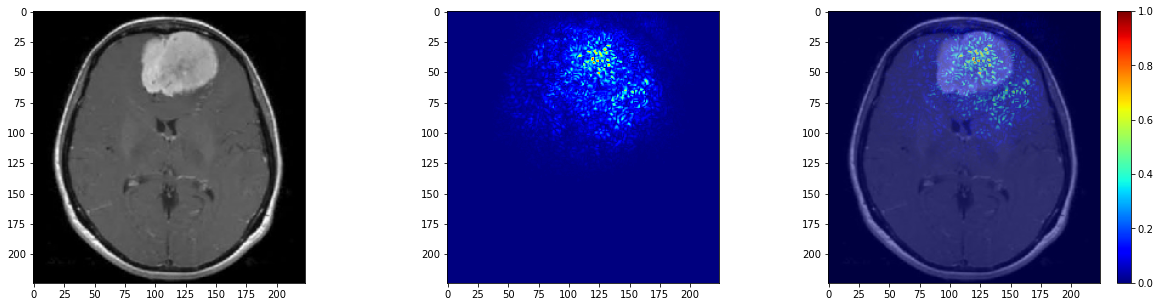

In [14]:
vgg16_gradient_activation_maps(r'Testing/meningioma/Te-me_0077.jpg', 'meningioma')

notumor


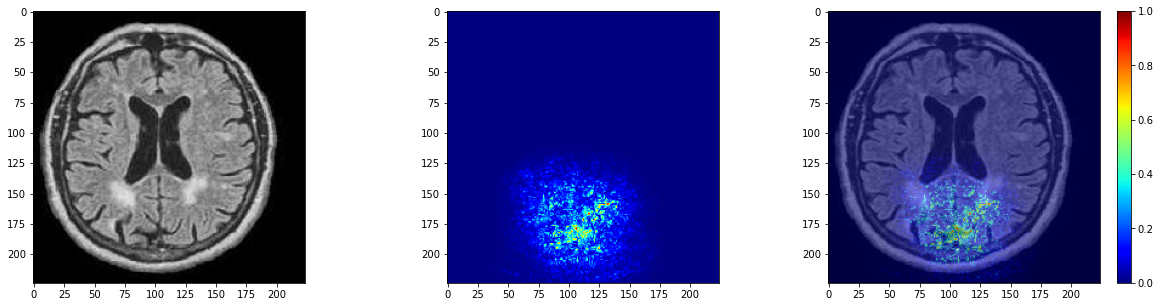

In [15]:
vgg16_gradient_activation_maps(r'Testing/notumor/Te-no_0336.jpg', 'notumor')

pituitary


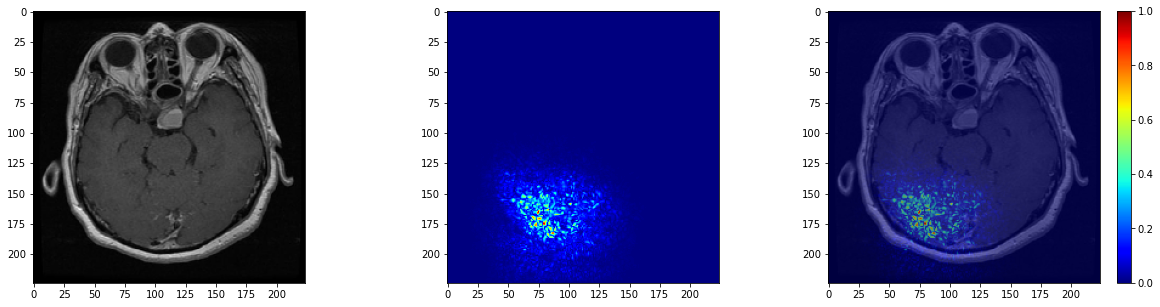

In [16]:
vgg16_gradient_activation_maps(r'Testing/pituitary/Te-pi_0027.jpg', 'pituitary')

### Ensemble Techniques using all models.

In [2]:
model_predictions_train = pd.read_csv('model_predictions_train.csv',index_col='Unnamed: 0')
model_predictions_test = pd.read_csv('model_predictions_test.csv',index_col='Unnamed: 0')

#### Individual Model Accuracy

In [4]:
accuracy = pd.DataFrame(columns = ['train','test'], index = ['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']).fillna(0.0)

for i in accuracy.index.values:
    accuracy.loc[i,'train'] = round(accuracy_score(model_predictions_train['actual'], model_predictions_train[i])*100,2)
    
for i in accuracy.index.values:
    accuracy.loc[i,'test'] = round(accuracy_score(model_predictions_test['actual'], model_predictions_test[i])*100,2)
    
print(accuracy)

                    train   test
3c2f                94.87  91.84
vgg16               98.81  97.33
vgg16_ctrained      99.42  97.48
resnet              98.91  97.48
resnet_ctrained     99.46  98.40
inception           98.28  96.34
inception_ctrained  98.28  97.33


#### Voting

In [3]:
def voting_predict(df):
    
    df['predicted_Voting'] = 'notumor'
    
    for i in df.index.values:
        if i != 'actual':
        
            classes_dict = {'glioma': 0,'meningioma':0,'notumor':0,'pituitary':0}
        
            models = df.columns.values
            for j in models:
                classes_dict[df.loc[i,j]] = classes_dict[df.loc[i,j]]+1 
        
            df.loc[i,'predicted_Voting'] = max(classes_dict.items(), key=operator.itemgetter(1))[0]
    
    return df

In [4]:
emsemble_train_predict = voting_predict(model_predictions_train)
emsemble_test_predict = voting_predict(model_predictions_test)

In [5]:
print('Train Accuracy is ', round(accuracy_score(emsemble_train_predict['actual'], emsemble_train_predict['predicted_Voting'])*100,2)) 
print('Test Accuracy is ', round(accuracy_score(emsemble_test_predict['actual'], emsemble_test_predict['predicted_Voting'])*100,2))

Train Accuracy is  99.89
Test Accuracy is  99.16


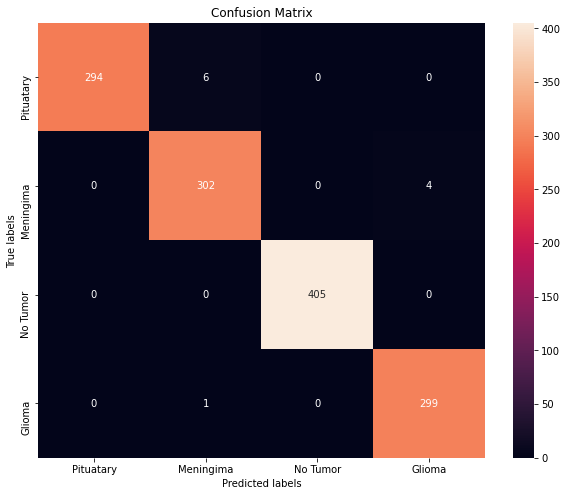

In [7]:
plt.figure(figsize=(10, 8))
ax= plt.subplot()
cm = confusion_matrix(emsemble_test_predict['actual'], emsemble_test_predict['predicted_Voting'])
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']); ax.yaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']);

In [23]:
# Incorectly predicted test cases.
emsemble_test_predict[emsemble_test_predict['actual']!=emsemble_test_predict['predicted_Voting']]

,3c2f,vgg16,vgg16_ctrained,resnet,resnet_ctrained,inception,inception_ctrained,actual,predicted_Voting
Testing/glioma/Te-gl_0232.jpg,meningioma,meningioma,meningioma,meningioma,meningioma,glioma,glioma,glioma,meningioma
Testing/glioma/Te-gl_0237.jpg,meningioma,meningioma,meningioma,meningioma,glioma,glioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0255.jpg,meningioma,meningioma,meningioma,glioma,glioma,meningioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0265.jpg,meningioma,meningioma,meningioma,meningioma,glioma,meningioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0276.jpg,meningioma,meningioma,meningioma,meningioma,meningioma,glioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0277.jpg,meningioma,meningioma,glioma,meningioma,meningioma,meningioma,glioma,glioma,meningioma
Testing/meningioma/Te-meTr_0002.jpg,notumor,pituitary,pituitary,pituitary,pituitary,meningioma,meningioma,meningioma,pituitary
Testing/meningioma/Te-me_0140.jpg,notumor,pituitary,pituitary,pituitary,pituitary,meningioma,meningioma,meningioma,pituitary
Testing/meningioma/Te-me_0287.jpg,pituitary,pituitary,meningioma,pituitary,pituitary,pituitary,pituitary,meningioma,pituitary
Testing/meningioma/Te-me_0292.jpg,pituitary,meningioma,meningioma,pituitary,pituitary,pituitary,pituitary,meningioma,pituitary


#### Random Forest

In [9]:
X = model_predictions_train[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y = model_predictions_train['actual']

X_val = model_predictions_test[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y_val = model_predictions_test['actual']

X = pd.get_dummies(X)
X_val = pd.get_dummies(X_val)

# from sklearn.datasets import make_multilabel_classification
# X, y = make_multilabel_classification(n_features=4, random_state=7,n_classes=4)
# X_val, y_val = make_multilabel_classification(n_features=4, random_state=7,n_classes=4)


model = RandomForestClassifier(random_state=7)
model.fit(X,y)

prediction_train = model.predict(X)
prediction_val = model.predict(X_val)

print('Train Accuracy is ', round(accuracy_score(y, prediction_train)*100,2))
print('Test Accuracy is ', round(accuracy_score(y_val, prediction_val)*100,2))

Train Accuracy is  99.96
Test Accuracy is  98.93


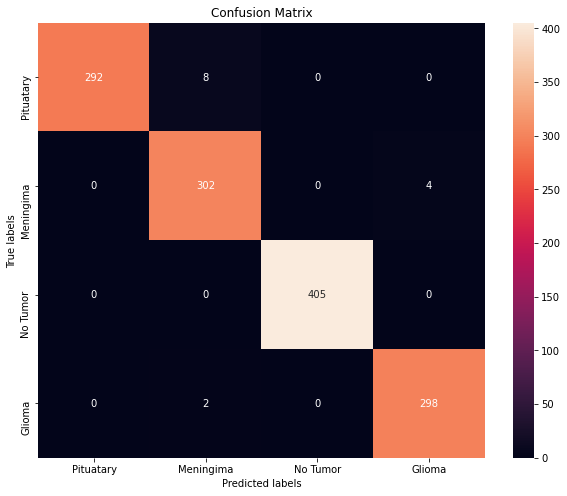

In [10]:
plt.figure(figsize=(10, 8))
ax= plt.subplot()
cm = confusion_matrix(model_predictions_test['actual'], prediction_val)
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']); ax.yaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']);

#### XGBoost

In [11]:
X = model_predictions_train[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y = model_predictions_train['actual']

X_val = model_predictions_test[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y_val = model_predictions_test['actual']

X = pd.get_dummies(X)
X_val = pd.get_dummies(X_val)

# from sklearn.datasets import make_multilabel_classification
# X, y = make_multilabel_classification(n_features=4, random_state=7,n_classes=4)
# X_val, y_val = make_multilabel_classification(n_features=4, random_state=7,n_classes=4)


model = XGBClassifier(learning_rate=0.2, max_depth=4,seed=7,eval_metric = 'mlogloss')
model.fit(X,y)

prediction_train = model.predict(X)
prediction_val = model.predict(X_val)

print('Train Accuracy is ', round(accuracy_score(y, prediction_train)*100,2))
print('Test Accuracy is ', round(accuracy_score(y_val, prediction_val)*100,2))

Train Accuracy is  99.96
Test Accuracy is  99.01


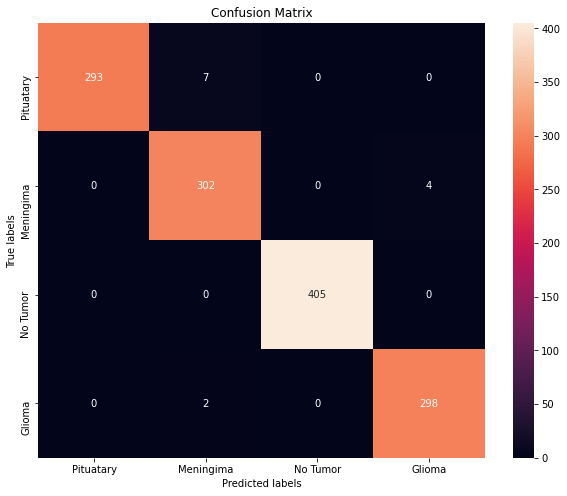

In [12]:
plt.figure(figsize=(10, 8))
ax= plt.subplot()
cm = confusion_matrix(model_predictions_test['actual'], prediction_val)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']); ax.yaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']);